In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import cvlib
import plot

In [209]:
PATH = '/Users/estebansamayoa/Desktop/CS UFM/8vo Semestre/Computer Vision/imagenes/'

img=cvlib.imgread(PATH+'leaf.png')

In [210]:
img.shape

(217, 288)

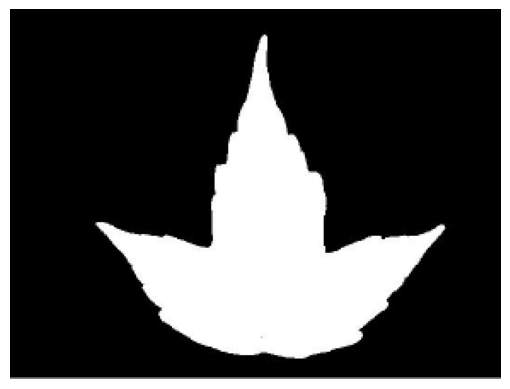

In [211]:
cvlib.imgview(img)

In [182]:
def imgpad(img, r):
    '''
        La función de imgpad recibe como parámetro una imagen en formato ndarray, y una variable r, que es el tamaño del Padding que se hará 
        alrededor de la imagen. 
        Luego, revisar el shape de la imagen, para ver si es a color (en ese caso tendría 3 layers de color), o si es en grayscale,
        la cual solo tendría 2 dimensiones (ancho y alto). 
        Maneja cada caso de manera diferente:
            - Si tiene 3 dimensiones hace el padding en cada una de los layers de color, haciendo un for loop para recorrer cada layer.
            Luego, se crea una matriz de valores 255 (blanco), que sea mas grande que la imagen, luego los pixeles de la imagen original
            se copian dentro de la nueva matriz creada, y esto se hace por cada uno de los layers, que son 3.
            - Si tiene solo dos dimensiones, no es necesario hacer el loop por cada dimensión ya que solo tiene una, entoces realiza la misma función,
            pero sin la cantidad de layers. Hace una matriz de valores 255, y se copian los valores de la img dentro de la nueva matriz. 
    '''
    if len(img.shape) == 3:
        height, width, layers = img.shape
        padded_img = np.full((height + 2 * r, width + 2 * r, layers), 255, dtype=img.dtype)

        for i in range(layers):
            padded_img[r:r+height, r:r+width, i] = img[:, :, i]
    elif len(img.shape) == 2:
        height, width = img.shape
        padded_img = np.full((height + 2 * r, width + 2 * r), 255, dtype=img.dtype)
        padded_img[r:r+height, r:r+width] = img
    else:
        raise ValueError("No se puede hacer Padding en la imagen, ya que no soporta las dimensiones")

    return padded_img


In [185]:
padded_img=imgpad(img, 25);

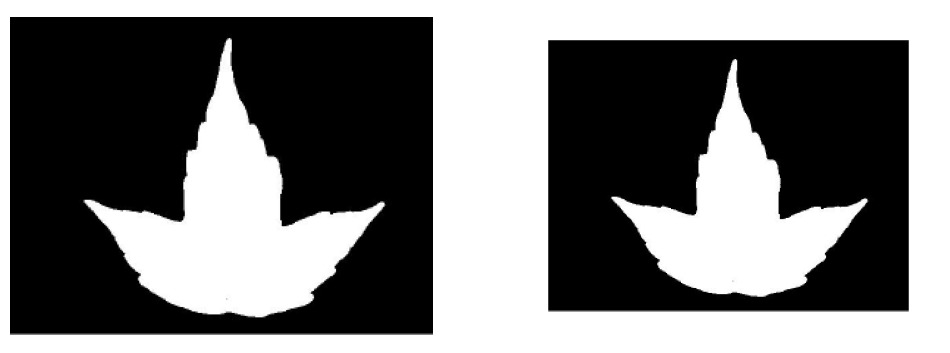

In [186]:
cvlib.imgcmp(img, padded_img);

In [230]:
PATH = '/Users/estebansamayoa/Desktop/CS UFM/8vo Semestre/Computer Vision/laboratorio1/'

img = cvlib.imgread(PATH+'fprint3.pgm')

img = cv.imread(PATH+'fprint3.pgm', cv.IMREAD_GRAYSCALE)


In [231]:
img.shape

(768, 768)

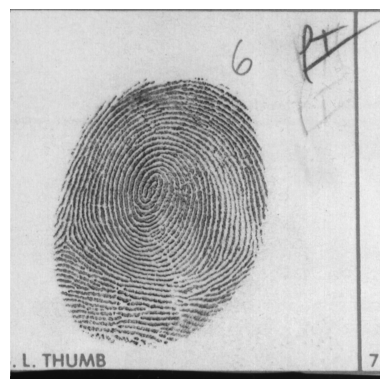

In [232]:
cvlib.imgview(img)

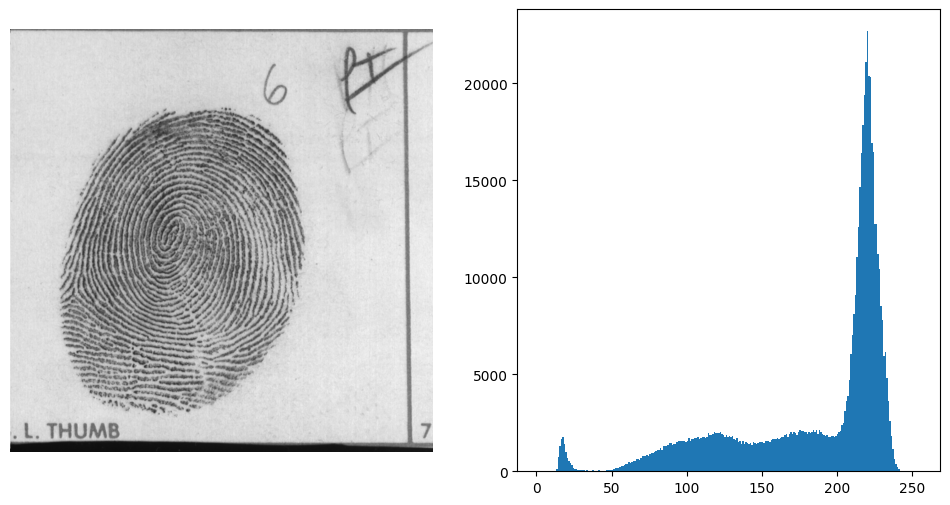

In [233]:
cvlib.hist(img)

In [234]:
def thresholding(img, threshhold):
    """
    Hace una binarización de los valores de la imagen que se le envía y luego, invierte los colores, es decir 
    los valores de 255 los vuelve 0 y viceversa.
    """
    binary_image = cv.threshold(img, threshhold, 255, cv.THRESH_BINARY)[1]
    binary_image = cv.bitwise_not(binary_image)
    return binary_image

In [235]:
binary_img=thresholding(img, 125)
binary_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

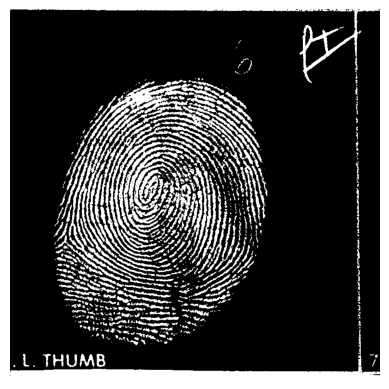

In [236]:
cvlib.imgview(binary_img)

In [227]:
def connected_c(img):
    '''
    La función connected_C toma una imagen binaria y etiqueta los componentes conectados en la imagen asignandole números enteros 
    a cada componente.
    Esta función recibe como parámetro una imagen, para luego crear un arreglo de 0 de las mismas dimensiones y alli ir 
    actualizando los valores, esto se logra pasando por la función dividida en dos iteraciones 
    (que se escanean primero por columna, la cual sería el width y despues por fila, que es el height):
        - En la primera iteración se busca el primer pixel en la imagen que tenga como valor 0, luego se crea un arreglo de sus 
        valores vecinos que sean mayores al valor 0. Si no encuentra ninguno, agrega este pixel como un nuevo label y lo agrega 
        a un diccionario. Si en caso la lista no esta vacía, busca el valor del vecino más baja que no sea 0 y se lo aplica al pixel actual.
        Luego con un for se manda a llamar la subfunción de union, la cual le asigna esta etiqueta a todos los pixeles del grupo que no 
        lo tengan y así que todo el grupo tenga la misma.
        - Luego en la segunda iteración se ve que todos los valores sean mayores a 0, para luego llamar a una subfunción que encuentra el 
        lable original, es decir el valor de donde se saco el label y le asigna al pixel el label de la raíz, el cual es de valor más bajo.

    '''
    def raiz_comp(label):
        while lables_t[label] != label:
            label = lables_t[label]
        return label

    def union(label1, label2):
        root1 = raiz_comp(label1)
        root2 = raiz_comp(label2)
        if root1 != root2:
            lables_t[root1] = root2

    height, width = img.shape
    lables_t = {}
    next_label = 1  

    labeled_img = np.zeros_like(img, dtype=np.uint16)

    for x in range(width):  
        for y in range(height):  
            if img[y, x] == 0:
                neighbors = []
                if x > 0 and labeled_img[y, x - 1] > 0:
                    neighbors.append(labeled_img[y, x - 1])
                if y > 0 and labeled_img[y - 1, x] > 0:
                    neighbors.append(labeled_img[y - 1, x])

                if not neighbors:
                    labeled_img[y, x] = next_label
                    lables_t[next_label] = next_label
                    next_label += 1
                else:
                    min_neighbor = min(neighbors)
                    labeled_img[y, x] = min_neighbor
                    for neighbor in neighbors:
                        if neighbor != min_neighbor:
                            union(min_neighbor, neighbor)

    for x in range(width):  
        for y in range(height):
            if labeled_img[y, x] > 0:
                labeled_img[y, x] = raiz_comp(labeled_img[y, x])

    return labeled_img


In [229]:
labeled_image=connected_c(binary_img)
np.unique(labeled_image)

array([ 0,  1, 58, 59], dtype=uint16)

In [225]:
def labelview(labels):
    '''
        Esta función recibe como parametros los labels creados en connected_c, y saca los valores unicos del arreglo.
        Despues le asigna un color random a cada label y lo almacena dentro de un diccionario. Luego crea, un arreglo de 0 con las mismas
        dimensiones que la imagen y a cada label le va asignando un pixel de color. Por ultimo muestra la imagen.
    '''
    unique_labels = np.unique(labels)
    label_colors = {}

    for label in unique_labels:
        if label == 0: 
            continue
        label_colors[label] = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

    colored_image = np.zeros((*labels.shape, 3), dtype=np.uint8)
    for label, color in label_colors.items():
        colored_image[labels == label] = color


    cvlib.imgview(colored_image)

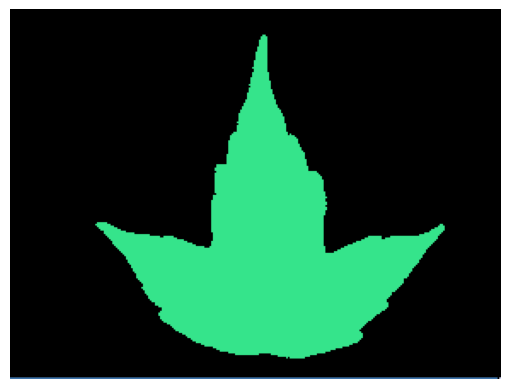

In [226]:
# No logré probarlo con la huella digital, porque se tardó mucho en procesarla, llevaba más de 1 hora. Pero probe hacerlo con otra imagen.
labelview(labeled_image)